### Develop LSTM Models For Univariate Time Series Forecasting

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore")

2022-03-22 18:46:40.084145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 18:46:40.084185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('rice_wheat_corn_prices.csv')
#make the date index
df['Date'] = np.zeros(len(df))
for i in range(len(df)):
    df['Date'][i] = '-'.join([str(df['Year'][i]),df['Month'][i],'01']) 
df['Date']= pd.to_datetime(df['Date'], format='%Y-%b-%d')
df = df.dropna()
df.set_index('Date',inplace = True)
ser = df.Price_wheat_ton
df  =ser.to_frame()
print(df)

,Price_wheat_ton
Date,
1992-02-01,170.12
1992-03-01,161.44
1992-04-01,153.07
1992-05-01,139.72
1992-06-01,140.36
...,...
2021-08-01,276.18
2021-09-01,263.60
2021-10-01,334.50


In [3]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_features
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
# define input sequence
timeseries_data = df.Price_wheat_ton
# choose a number of time steps
n_steps = 30
# split into samples
X, y = prepare_data(timeseries_data, n_steps)

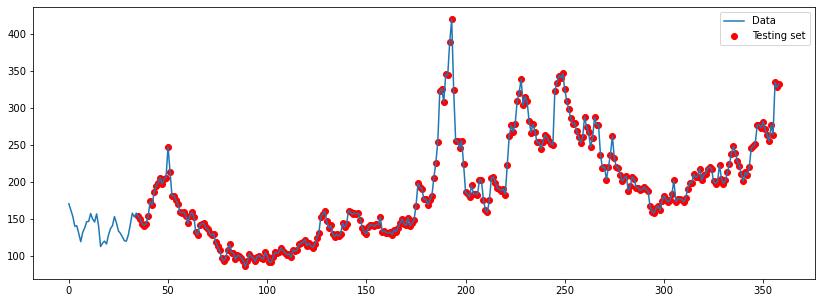

In [5]:
plot_x = np.arange(0,len(df))
fig,ax = plt.subplots(figsize=(14,5))
ax.plot(plot_x,df.Price_wheat_ton,label= 'Data')
ax.scatter(plot_x[n_steps:], y,color = 'r',label = 'Testing set')
ax.legend()
plt.show()

In [6]:
X.shape # 356 batches of 3 data points, so it predicts the 4th value from the previous 3

(324, 35)

In [7]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1    # 1 value to predict
X = X.reshape((X.shape[0], X.shape[1], n_features)) #for model
X.shape

(324, 35, 1)

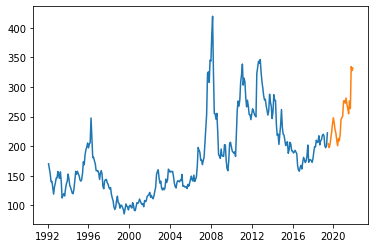

In [8]:
#preparing the data 
#cut the last 30 for testing
pred_idx = len(df)-30
timeseries_data = df.iloc[:pred_idx]
#check is correct
plt.plot(timeseries_data)
plt.plot(df.Price_wheat_ton[-30:]);



In [9]:
#scale it
scaler = MinMaxScaler()
scaler.fit(timeseries_data)
timeseries_data = scaler.transform(timeseries_data)
timeseries_data
X, y = prepare_data(timeseries_data, n_steps)

X = X.reshape((X.shape[0], X.shape[1], n_features)) #for model
print(X.shape)

(294, 35, 1)

### Building LSTM Model

In [10]:
# define model
model = Sequential()
model.add(LSTM(170, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))

model.add(LSTM(170, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=250, verbose=False);


2022-03-22 18:46:44.352090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-22 18:46:44.352166: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 18:46:44.352218: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MazaMint): /proc/driver/nvidia/version does not exist
2022-03-22 18:46:44.352607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Predicting For the next 30 data

In [11]:
# demonstrate prediction for next 30 months
x_input = np.squeeze(X[-1])


temp_input=list(x_input)

lst_output=[]
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

#print(lst_output)

In [12]:
pred = np.array(lst_output).reshape(1, -1)
true_predictions = scaler.inverse_transform(pred)[0]
#true_predictions

array([208.85332, 216.84442, 224.03154, 230.62206, 236.79765, 241.94998,
       245.22379, 247.50964, 249.63734, 249.78406, 246.85336, 241.31772,
       234.46402, 228.21304, 224.23302, 222.75336, 222.80942, 223.29356,
       223.55856, 223.82404, 223.89708, 223.69203, 224.14622, 226.15868,
       228.97725, 230.01959, 227.06117, 219.28722, 208.2008 , 197.98892],
      dtype=float32)

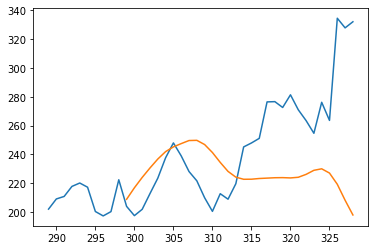

In [13]:
x_plot = np.arange(0,len(timeseries_data))

plt.plot(x_plot[-40:],df.Price_wheat_ton[-40:])
plt.plot(x_plot[-30:],true_predictions);